In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from collections import Counter

import seaborn as sns
from statsmodels.tsa.api import adfuller
import yahoo_finance as yf
import pandas_datareader as pdr

In [2]:
# Modify some settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 150

pd.options.display.max_rows = 20
pd.options.display.max_columns = 15

In [3]:
data = pd.read_csv('~/k_means/Data/sp_financials.csv')
data = data.drop(['SEC_Filings', 'Sector', 'Name'], axis=1)
symbol = data['Symbol']
data = data.set_index('Symbol')
data = data.fillna(0)
cols = ['Price', 'Price/Earnings', 'Dividend_Yield', 'Earnings/Share',
       '52_Week_Low', '52_Week_High', 'Market_Cap', 'EBITDA', 'Price/Sales',
       'Price/Book']
data = data[['Price', 'Price/Earnings', 'Dividend_Yield', 'Earnings/Share',
       '52_Week_Low', '52_Week_High', 'Market_Cap', 'EBITDA', 'Price/Sales',
       'Price/Book']]
data.head()

,Price,Price/Earnings,Dividend_Yield,Earnings/Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price/Sales,Price/Book
Symbol,,,,,,,,,,
MMM,222.89,24.31,2.332862,7.92,259.77,175.490,1.387210e+11,9.048000e+09,4.390271,11.34
AOS,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35
ABT,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19
ABBV,108.48,19.41,2.499560,3.29,125.86,60.050,1.813860e+11,1.031000e+10,6.291571,26.14
ACN,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62


In [4]:
# standardize data to have mean ~0 and var of 1
data_std = StandardScaler().fit_transform(data)
# save for later in df form
ds = pd.DataFrame(data_std, columns=cols)
ds = ds.set_index(symbol)

In [5]:
# implement model with K found above
kmeans = KMeans(n_clusters = 28, init='k-means++', random_state=42)
label = kmeans.fit_predict(data_std)
u_labels = np.unique(label)
centroids = kmeans.cluster_centers_

In [6]:
# lets choose cluster 21 as an example and choose the stocks for our model
ds['label'] = label
cluster = ds[ds['label'] == 0]
ds

,Price,Price/Earnings,Dividend_Yield,Earnings/Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price/Sales,Price/Book,label
Symbol,,,,,,,,,,,
MMM,0.886554,-0.009724,0.284503,0.733057,0.883627,0.870600,0.994671,0.798633,0.129768,-0.032452,15
AOS,-0.324590,0.074119,-0.487073,-0.361358,-0.349426,-0.327697,-0.427474,-0.437435,-0.105946,-0.088598,27
ABT,-0.354152,-0.053469,0.008484,-0.614728,-0.373845,-0.390611,0.587828,0.315151,-0.058213,-0.124153,21
ABBV,0.034621,-0.128807,0.393052,-0.081596,0.020850,-0.222367,1.468932,0.983304,0.679804,0.134072,21
ACN,0.347590,0.018467,-0.118177,0.296699,0.257565,0.296186,0.550532,0.300405,-0.386957,-0.040553,1
...,...,...,...,...,...,...,...,...,...,...,...
XYL,-0.250127,0.151402,-0.472669,-0.338484,-0.295177,-0.347248,-0.403780,-0.419729,-0.351636,-0.100299,27
YUM,-0.205002,0.061725,-0.064384,0.055646,-0.229974,-0.195858,-0.247175,-0.190426,0.686187,2.226193,6
ZBH,0.087117,-0.252507,-0.717019,0.924844,0.070010,0.233225,-0.275505,-0.231633,-0.224727,-0.133154,1


In [7]:
'''
cluster_count = Counter(ds['label'])
cluster_pairs_df = pd.DataFrame()
test = pd.concat(i for cluster_count, i in ds.groupby(ds['label']) if len(i) > 1)
test = test.groupby(ds['label'] == '21')
test.head()
'''

"\ncluster_count = Counter(ds['label'])\ncluster_pairs_df = pd.DataFrame()\ntest = pd.concat(i for cluster_count, i in ds.groupby(ds['label']) if len(i) > 1)\ntest = test.groupby(ds['label'] == '21')\ntest.head()\n"

In [8]:
class statarb(object):
    '''
    k-means object with ..... atributes 
    methods
    -------
        create_spread:
        check_cointergration:
        generate_signal:
        generate_returns:
        inputs: 
        attributes:
    -----
    '''
    def __init__(self, df1, df2, s1, s2, ma, floor, ceiling, stop_loss_long, stop_loss_short, beta_lookback, start, end, exit_zscore=0):
        self.df1 = df1 # dataframe of stock one
        self.df2 = df2 # dataframe of stock two
        self.s1 = s1 # name of stock one
        self.s2 = s2 # name of stock two        
        self.df = pd.DataFrame(index = df1.index) # new df for data_cleaning method
        self.ma = ma # moving average period
        self.floor = floor # buy threshold for z-score
        self.ceiling = ceiling # sell threshold for z-score
        self.stop_loss_long = stop_loss_long # z-score continues to drop through our floor
        self.stop_loss_short = stop_loss_short # z-score continues to rise through our ceiling 
        self.Close = 'Close Long'
        self.Cover = 'Cover Short'
        self.beta_lookback = beta_lookback # lookback of beta for hedge ratio
        self.start = start # begining of test period
        self.end = end # end of test period
        self.exit_zscore = exit_zscore # z-score
        
    def create_spread(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			self: df: dataframe with chosen stock prices cov, var, beta, hedge ratio and spreads
		'''
        
        # take closing price of chose stocks and add to new dataframe
        self.df[self.s1] = self.df1['Close']
        self.df[self.s2] = self.df2['Close']
        
        # find beta values for pair of stocks. This beta is not the CAPM beta, 
        # its the general beta representing the partial slope coeffiecient in a multivariate
        # (in this case univariate) regression. Given this, it also represents the min variance hedge ratio. 
        # this is a rolling regression.
        ############# need to experiment with different values for lookback window
        self.df['cov'] = self.df[self.s1].rolling(self.beta_lookback).cov(self.df[self.s2])
        self.df['var'] = self.df[self.s2].rolling(self.beta_lookback).var()
        self.df['beta'] = self.df['cov'] / self.df['var']
        
        # set hedge ratio equal to beta of pair
        self.df['Hedge Ratio'] = self.df['beta']
        
        # the spread. For each stock_1 purchased we sell n * stock_2 where n is our hedge ratio
        # If the stocks are cointegrated, it implies the spread equation is stationary, I.E. mean and var are same over time
        # if we choose a hedge ratio such that the spread = 0, if there is cointegration the expected value of
        # the spread will stay = 0. Therefore, any deviation from this will present an opportunity of Stat Arb
        # We check for cointegration in the next method.
        self.df['Spread'] = np.log(self.df[self.s1]) - (self.df['Hedge Ratio']*np.log(self.df[self.s2]))
        self.df['Spread_2'] = np.log(self.df[self.s2]) - (self.df['Hedge Ratio']*np.log(self.df[self.s1]))
        
        with plt.style.context(['seaborn-paper']):
            ma1 = s1['Close'].rolling(window=28).mean()
            std1 = s1['Close'].rolling(window=28).std() 
            upper1 = ma1 + (std1 * 2)
            lower1 = ma1 - (std1 * 2)

            ma2 = s2['Close'].rolling(window=28).mean()
            std2 = s2['Close'].rolling(window=28).std() 
            upper2 = ma2 + (std2 * 2)
            lower2 = ma2 - (std2 * 2)

            plt.plot(s1['Close'],label=name_1)
            plt.plot(upper1, 'r', alpha=0.5)
            plt.plot(lower1, 'r', alpha=0.5)
            plt.plot(ma1, 'r', alpha=0.5)
            plt.fill_between(s1.index, upper1, lower1, alpha=0.1)
            plt.plot(s2['Close'],label=name_2)
            plt.plot(upper2, 'g', alpha=0.5)
            plt.plot(lower2, 'g', alpha=0.5)
            plt.plot(ma2, 'g', alpha=0.5)
            plt.fill_between(s1.index, upper2, lower2, alpha=0.1)
            plt.title(name_1 + ' and ' + name_2 + ' Over 2020 - 21')
            plt.legend(loc=0)
            plt.show()

        return self.df
    
    def check_cointergration(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			string: stated significance level of the chosen stock cointergration
		''' 
        ####### can imporve this method with matrix vectorization 
        # find coint
        # tells us on a given confidence level weather the par is cointegrated and thus stationary
        adf = adfuller(self.df['Spread'].dropna())
        # print appropriate response
        if adf[0] < adf[4]['1%']:
            print('Spread is Cointegrated at 1% Significance Level')
        elif adf[0] < adf[4]['5%']:
            print('Spread is Cointegrated at 5% Significance Level')
        elif adf[0] < adf[4]['10%']:
            print('Spread is Cointegrated at 10% Significance Level')
        else:
            print('Spread is not Cointegrated')
        return
    
    def generate_signal(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			self: df: dataframe with 1 or 0 values for long, short, and exit signals, and in position markers
		''' 
        # with an assumed distribution of spread ~N(0, 1), its is easy to form threshold levels 
        # these thresholds will act as signal levels 
        # Z = (X - mean) / SD
        # given time series mean and SD will be rolling, using a moving average window
        # create stock z score of the pair spread
        self.df['Z_Score'] = ((self.df['Spread'] - self.df['Spread'].rolling(window = self.ma).mean()) / (self.df['Spread'].rolling(window = self.ma).std()))

        # create prior stock z score        
        self.df['Prior_Z_Score'] = self.df['Z_Score'].shift(1)

        # use z scores to generate buy, sell, exit signals
        # floor and ceiling threshold should be between 1.5 and 2 sigma (change depending on backtest results)
        # LONG SIGNAL = LONG THE SPREAD: BUY STOCK 1, SELL STOCK 2
        # SHORT SIGNAL = SHORT THE SPREAD: SELL STOCK 1, BUY STOCK 2

        self.In_Short = False
        self.In_Long = False
        self.Stopped_Short = False
        self.Stopped_Long = False

        self.df['In_Short'] = 0.0
        self.df['In_Long'] = 0.0

        for i, j in enumerate(self.df.iterrows()):
            current_z = j[1]['Z_Score']
            # are we already in a short trade?
            if self.In_Short == True:
                # heave we been stopped out already?
                # define stop loss criteria
                if current_z >= self.stop_loss_short:
                    # exit trade if stop loss hit
                    # indicate we have been stopped out
                    self.In_Short = False
                    self.Stopped_Short = True
                    self.df.iloc[i]['In_Short'] = 0.0
                # if not stopped, have we hit close criteria?
                elif current_z <= self.exit_zscore:
                    self.In_Short = False
                    self.df.iloc[i]['In_Short'] = 0.0
                # if not stopped and not closed, still in trade
                else:
                    self.df.iloc[i]['In_Short'] = 1.0
            else:
                # why are we not in a short
                # have we been stopped out or did we close position?
                if self.Stopped_Short == True:
                    self.In_Short = False
                    self.df.iloc[i]['In_Short'] = 0.0
                    # if stopped, wait untill we reach exit critera to re-enter teade
                    if current_z <= self.exit_zscore:
                        self.Stopped_Short = False
                # define trade entry criteria
                elif current_z >= self.ceiling:
                    self.In_Short = True
                    self.Stopped_Short = False
                    self.df.iloc[i]['In_Short'] = 1.0       

            # are we already in a long trade?
            if self.In_Long == True:
                # define stop loss criteria
                if current_z <= self.stop_loss_long:
                    # exit trade if stop loss hit
                    # indicate we have been stopped out
                    self.In_Long = False
                    self.Stopped_Long = True
                    self.df.iloc[i]['In_Long'] = 0.0
                elif current_z >= self.exit_zscore:
                    self.In_Long = False
                    self.df.iloc[i]['In_Long'] = 0.0
                else:
                    self.df.iloc[i]['In_Long'] = 1.0
            else:
                # why are we not in a long
                # have we been stopped out or did we close position?
                if self.Stopped_Long == True:
                    self.In_Long = False
                    self.df.iloc[i]['In_Long'] = 0.0
                    if current_z >= self.exit_zscore:
                        self.Stopped_Long = False
                # define trade entry criteria
                elif current_z <= self.floor:
                    self.In_Long = True
                    self.Stopped_Long = False
                    self.df.iloc[i]['In_Long'] = 1.0 
        
        self.df['Floor'] = self.floor
        self.df['Ceiling'] = self.ceiling
        self.df['Long_Stop_Loss'] = self.stop_loss_long
        self.df['Short_Stop_Loss'] = self.stop_loss_short
        
        with plt.style.context(['seaborn-paper']):
            plt.plot(self.df['Z_Score'], label = 'Spread Z-Score')
            plt.plot(self.df['In_Long'], 'g', label = 'In Long Trade')
            plt.plot(self.df['In_Short'], 'r', label = 'In Short Trade')
            plt.plot(self.df['Floor'], 'g--', label = 'Entry Z-Score')
            plt.plot(self.df['Ceiling'], 'g--')
            plt.plot(self.df['Long_Stop_Loss'], 'r--', label = 'Stop Z-Score')
            plt.plot(self.df['Short_Stop_Loss'], 'r--')
            plt.legend(loc = 0)
            plt.tight_layout()
            plt.show()
        

        return self.df
    
    def generate_returns(self, allocation, pair):
        '''
		parameters
		----------
			self: object: statarb object
            allocation: int: desired dollar value for strategy 
            pair: string: names of two chosen stocks
		returns
		----------
			portfolio: df: dataframe with:  Positions,
                                            X,
                                            Y,
                                            Total,
                                            Returns,
                                            Win,
                                            Loss,
                                            Trade_Returns,
                                            Portfolio_Value,
                                            Portfolio_Returns,
                                            Initial_Value,
		''' 
        self.allocation = allocation
        self.pair = pair
        
        # set up portfolio dataframe
        self.portfolio = pd.DataFrame(index = self.df.index)
        # +1 Positions value = Long spread
        # -1 Positions values = Short spread
        self.portfolio['Long_Signal'] = self.df['In_Long']
        self.portfolio['Short_Signal'] = self.df['In_Short']
        self.portfolio['Positions'] = self.df['In_Long'] - self.df['In_Short']
        # Long stock shows negative value = price to represent cash outflow of bought share
        # short stock shows positive value = price to represent cash inflow of borrowed shares
        self.portfolio[self.s1] = -1 * (self.df[self.s1] * self.portfolio['Positions'])
        self.portfolio[self.s2] = (self.df[self.s2] * self.portfolio['Positions'])
        # Total shows current cumulative value of positions
        self.portfolio['Total'] = self.portfolio[self.s1] + self.portfolio[self.s2]
        
        # create percentage returns stream
        # find daily change of total market value of positions
        self.portfolio['Returns'] = self.portfolio['Total'].pct_change()
        self.portfolio['Returns'].fillna(0.0, inplace = True)
        # account for % changes where start = 0 as this would be infinite
        self.portfolio['Returns'].replace([np.inf, -np.inf], 0.0, inplace = True)
        self.portfolio['Returns'].replace(-1.0, 0.0, inplace = True)
        
        # calculate summary statistics
        self.mu = (self.portfolio['Returns'].mean())
        self.sigma = (self.portfolio['Returns'].std())
        self.sharpe = (self.mu - 0.005) / self.sigma
        # where True, yield x, otherwise yield y
        self.portfolio['Win'] = np.where(self.portfolio['Returns'] > 0.0, 1.0, 0.0)
        self.portfolio['Loss'] = np.where(self.portfolio['Returns'] < 0.0, 1.0, 0.0)
        self.wins = self.portfolio['Win'].sum()
        self.losses = self.portfolio['Loss'].sum()
        self.total_trades = self.wins + self.losses
        
        # win loss ratio
        self.wl_ratio = (self.wins / self.losses)
        
        # probability of win and loss
        self.p_win = (self.wins / self.total_trades)
        self.p_loss = (self.losses / self.total_trades)
        
        # avg win / loss return
        self.avg_win_return = (self.portfolio['Returns'] > 0.0).mean()
        self.avg_loss_return = (self.portfolio['Returns'] < 0.0).mean()
        
        # payout ratio
        self.payout_ratio = (self.avg_win_return / self.avg_loss_return)
        
        # getting equity curve
        self.portfolio['Returns'] = (self.portfolio['Returns'] + 1.0).cumprod()
        self.portfolio['Trade_Returns'] = (self.portfolio['Total'].pct_change())
        self.portfolio['Portfolio_Value'] = (self.allocation * self.portfolio['Returns'])
        self.portfolio['Portfolio_Returns'] = self.portfolio['Portfolio_Value'].pct_change()
        self.portfolio['Initial_Value'] = self.allocation
        
        # plot portfolio valuation
        with plt.style.context(['seaborn-paper']):
            plt.plot(self.portfolio['Portfolio_Value'])
            plt.plot(self.portfolio['Initial_Value'])
            plt.plot(self.df['In_Long']*10000, 'g', label = 'In Long Trade')
            plt.plot(self.df['In_Short']*10000, 'r', label = 'In Short Trade')
            plt.title('Statarb Pair %s Strategy Returns %s to %s' %(self.pair, self.start, self.end))
            plt.legend(loc = 0)
            plt.tight_layout()
            plt.show()
            
        return self.portfolio

In [9]:
cluster

,Price,Price/Earnings,Dividend_Yield,Earnings/Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price/Sales,Price/Book,label
Symbol,,,,,,,,,,,
EOG,-0.020780,5.388605,-0.822146,-1.008858,-0.023348,-0.014643,0.132553,0.014987,1.180703,-0.108850,0
NFLX,1.089169,4.261938,-1.234593,-0.440536,1.057844,0.518112,0.728822,-0.406994,1.712593,0.186504,0
SBAC,0.417138,4.255377,-1.234593,-0.551385,0.354660,0.189105,-0.329781,-0.368185,3.253843,0.864300,0
VRTX,0.355706,5.540010,-1.234593,-0.477486,0.337167,0.008080,-0.109715,-0.511104,3.542037,0.086477,0


In [10]:
X = cluster.index
Y = cluster.index

X_sqr = [[x, y] for x in X for y in Y]

pairs = []

ref = 0
for i in range(len(X)):
    for j in range(ref+1, int(np.sqrt(len(X_sqr)))):
        pairs.append(X_sqr[j+(ref * int(np.sqrt(len(X_sqr))))])
    ref += 1

####### need to work on vectorizing operations using np.arrays ########
# can use np.triu for above opperation
# update in future

pairs

[['EOG', 'NFLX'],
 ['EOG', 'SBAC'],
 ['EOG', 'VRTX'],
 ['NFLX', 'SBAC'],
 ['NFLX', 'VRTX'],
 ['SBAC', 'VRTX']]

EOG_NFLX


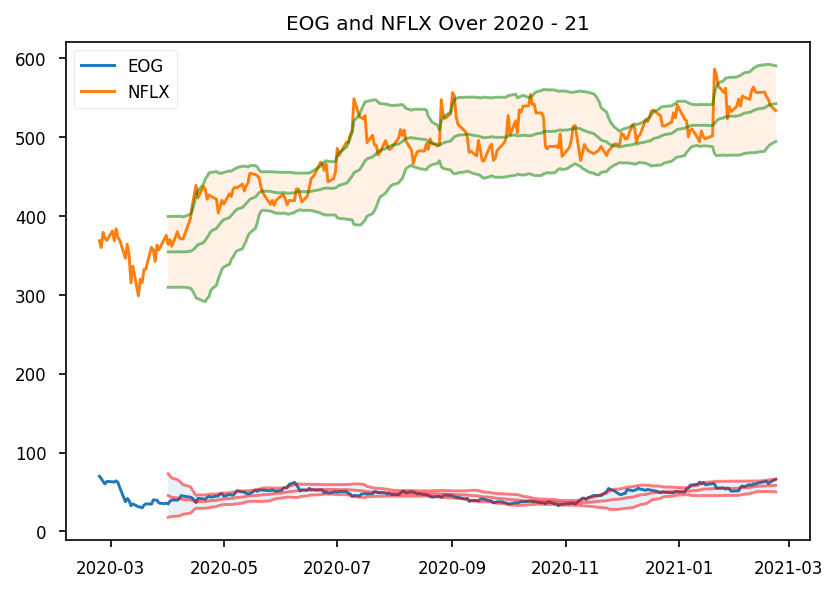

EOG NFLX
Spread is Cointegrated at 1% Significance Level


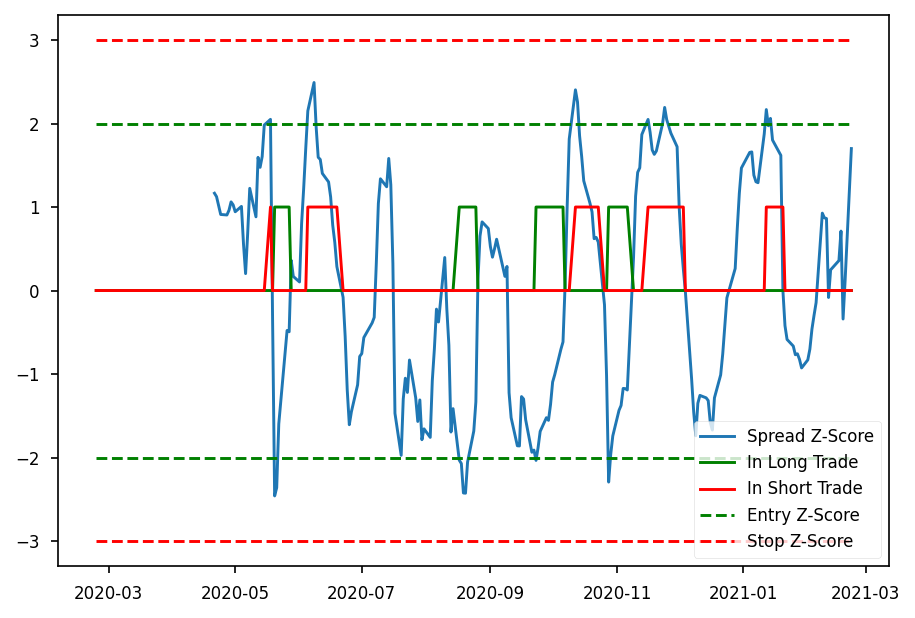

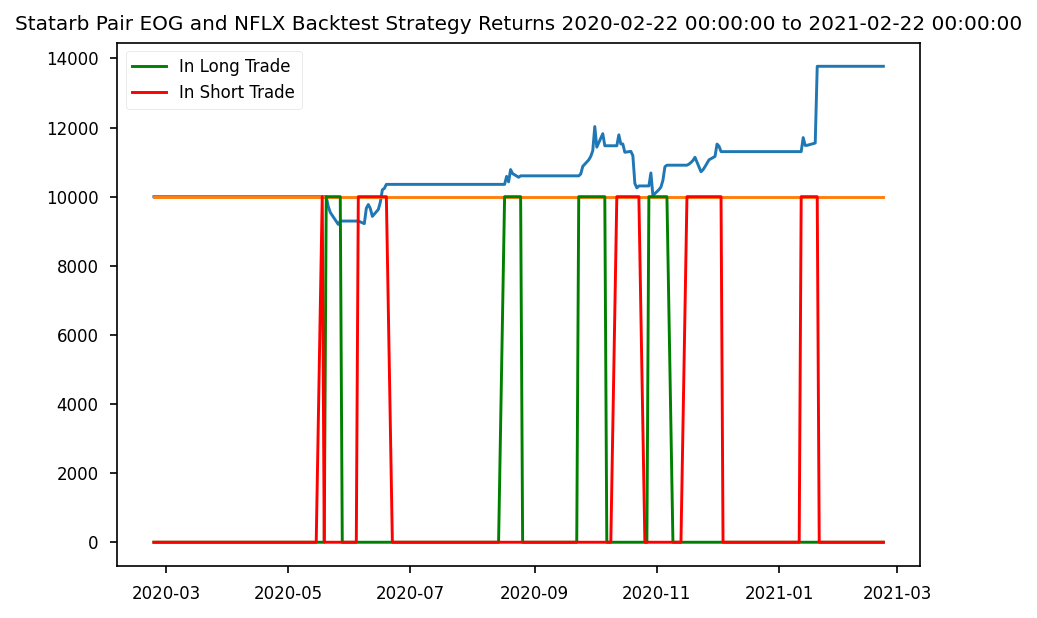

EOG_SBAC


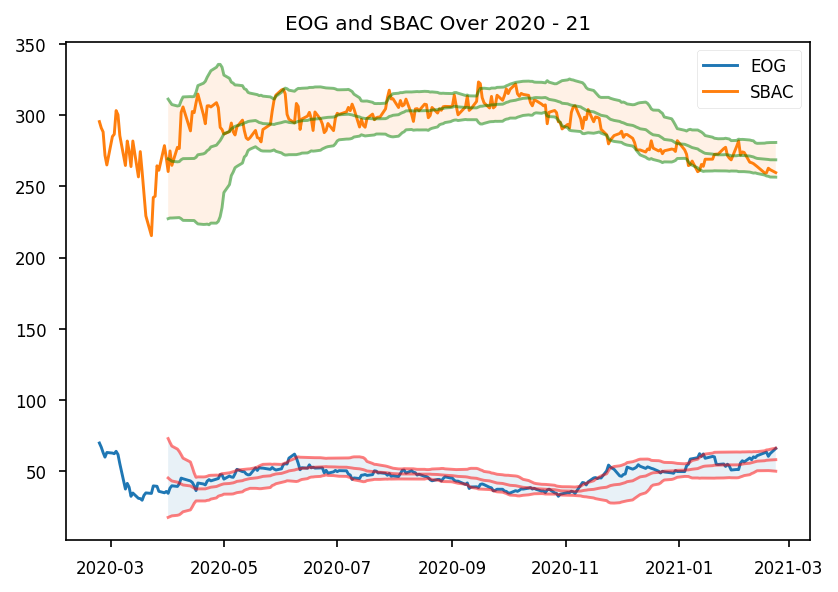

EOG SBAC
Spread is not Cointegrated


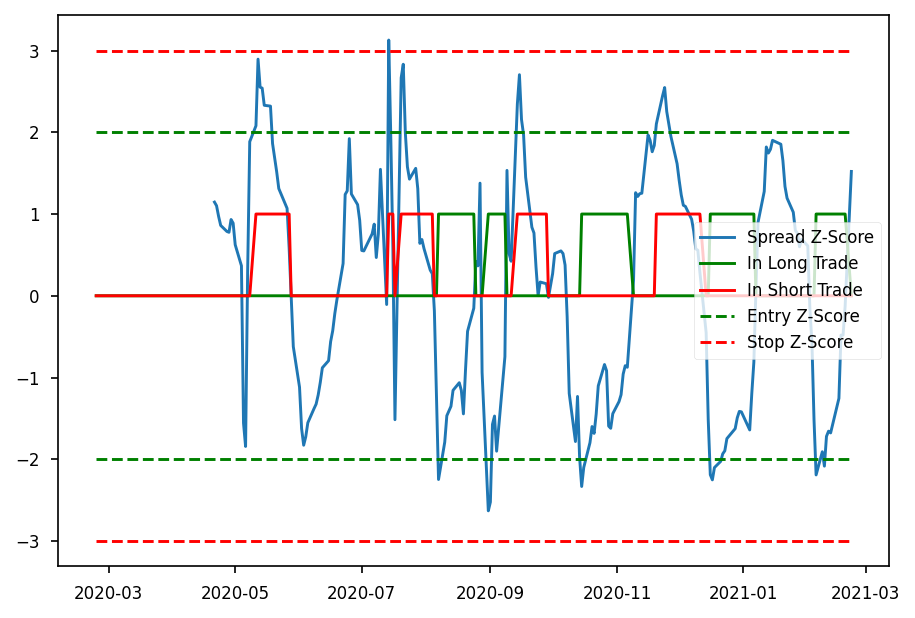

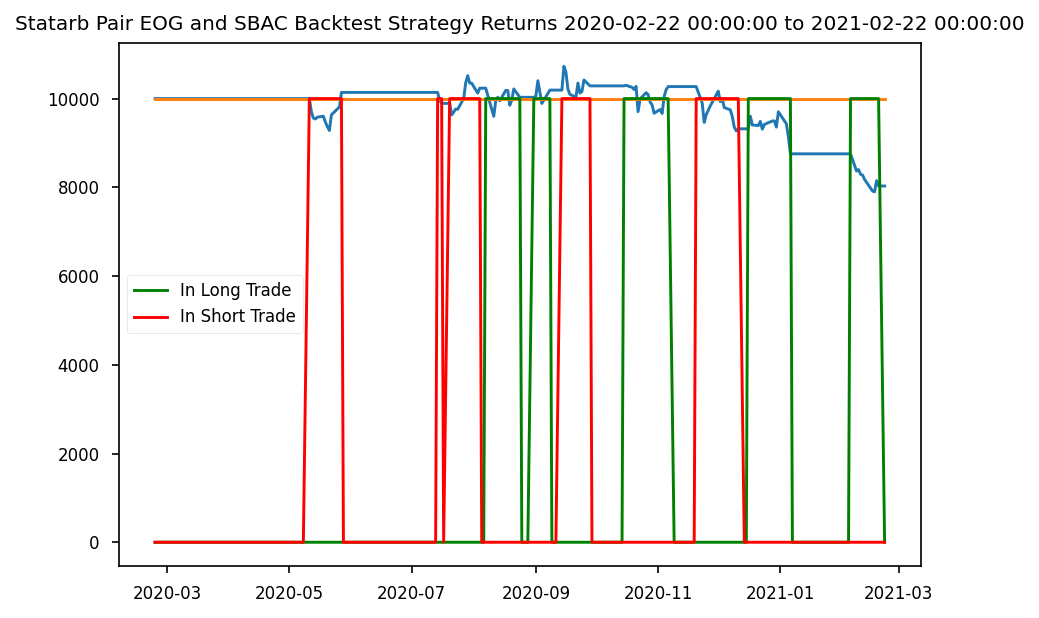

EOG_VRTX


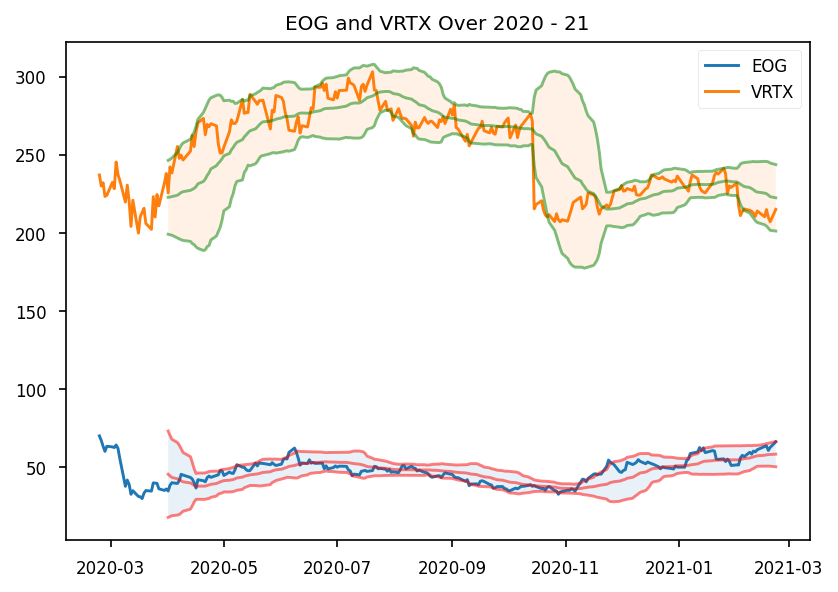

EOG VRTX
Spread is Cointegrated at 10% Significance Level


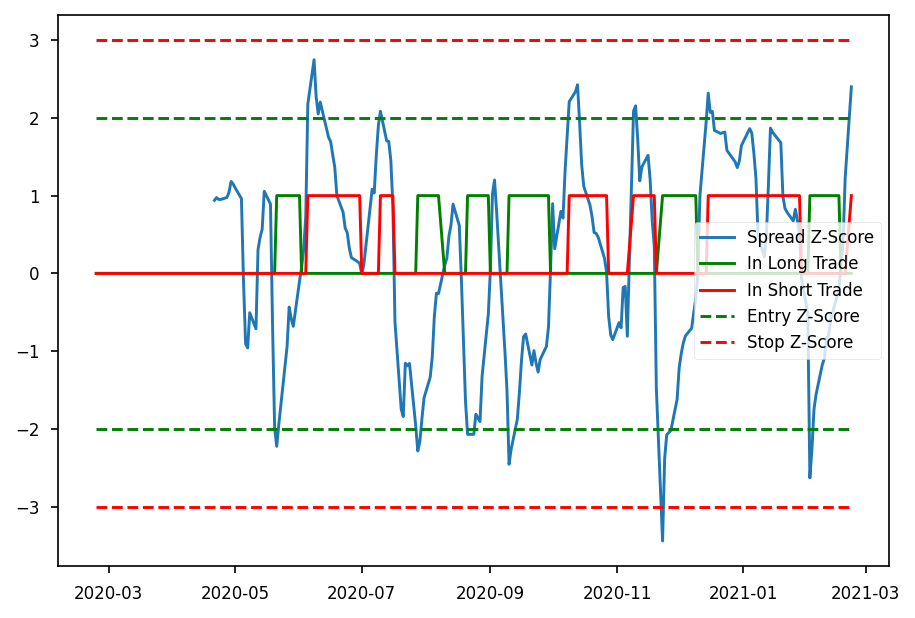

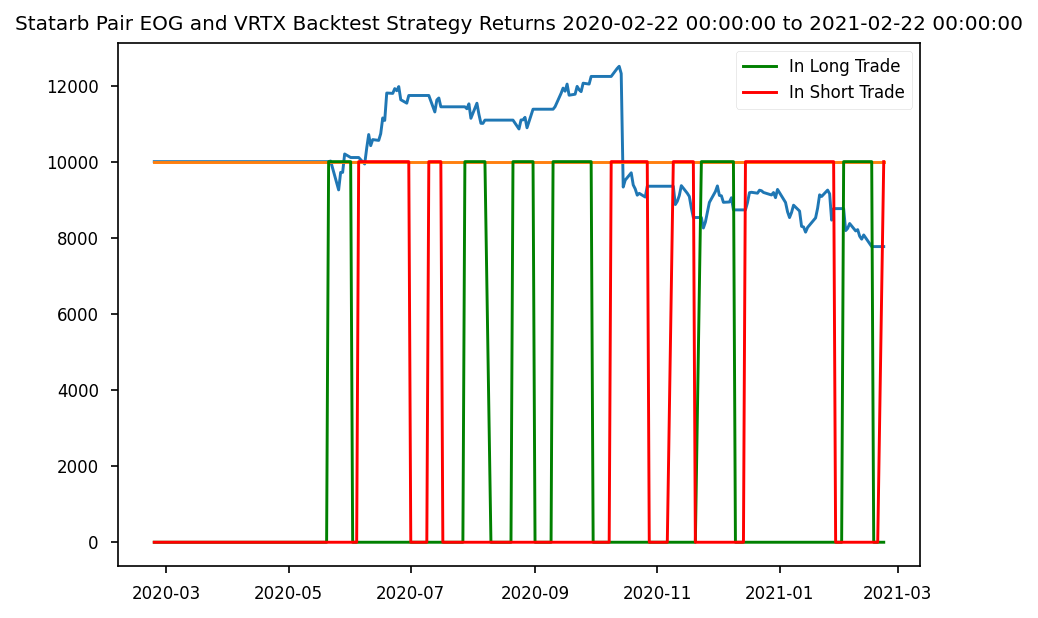

NFLX_SBAC


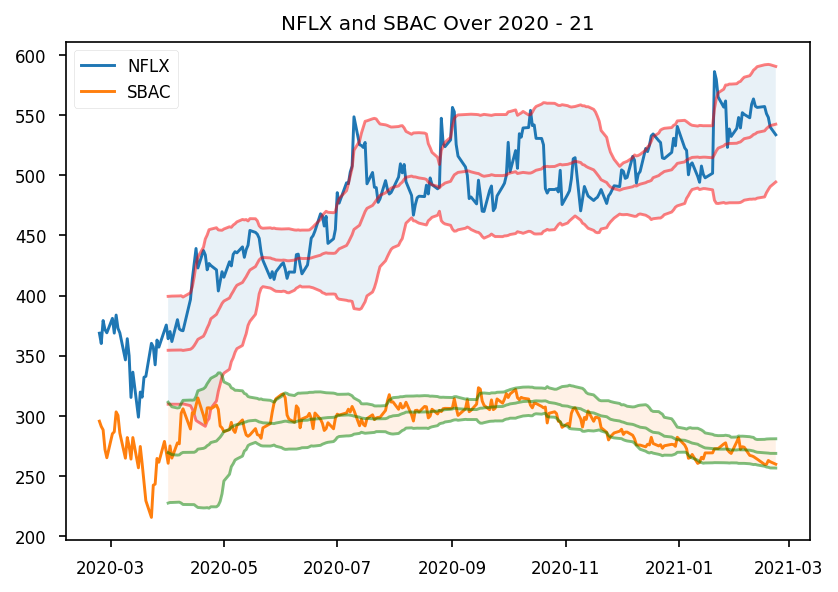

NFLX SBAC
Spread is Cointegrated at 1% Significance Level


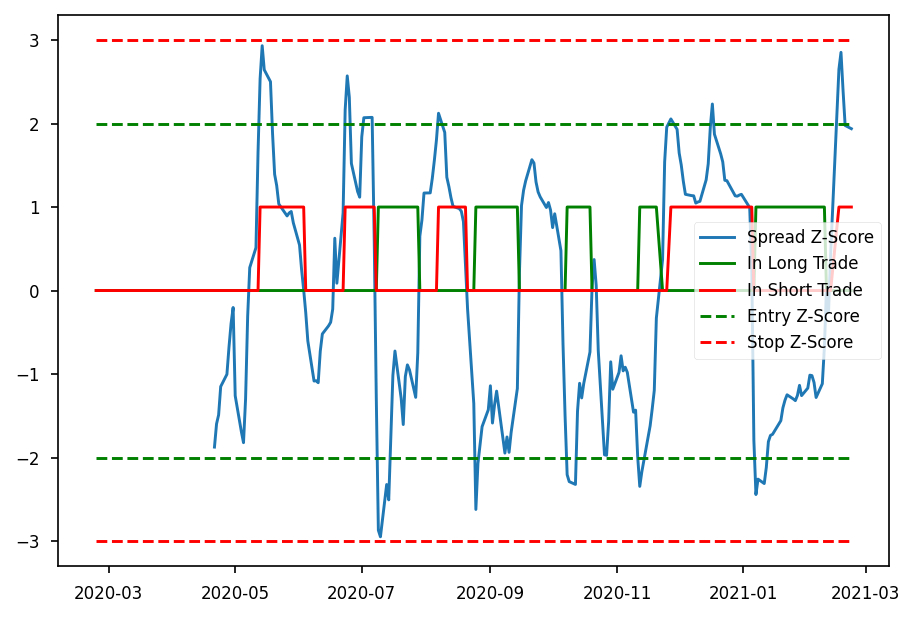

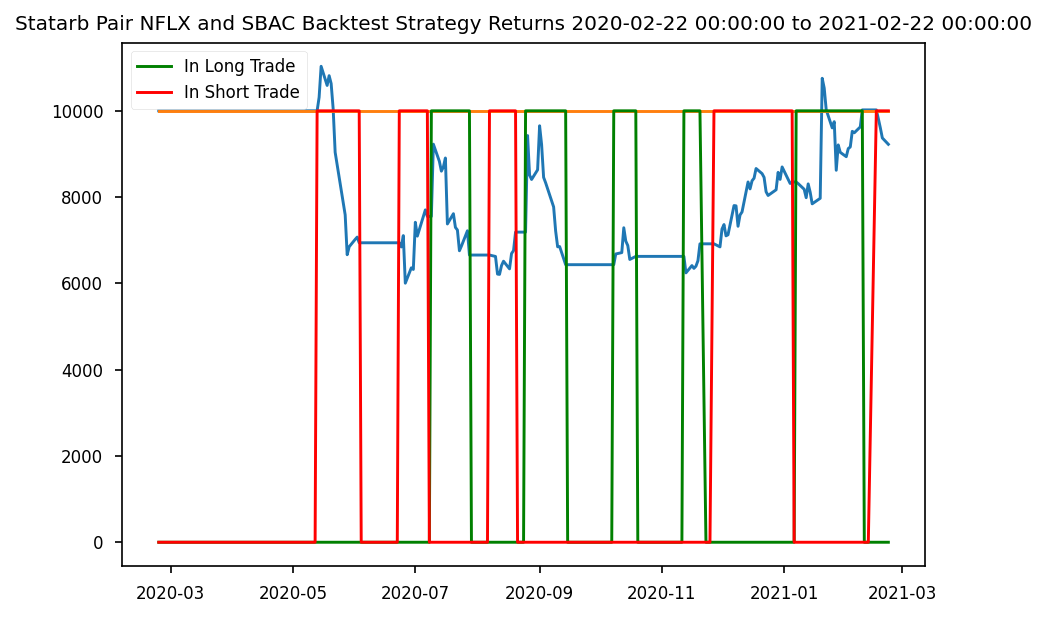

NFLX_VRTX


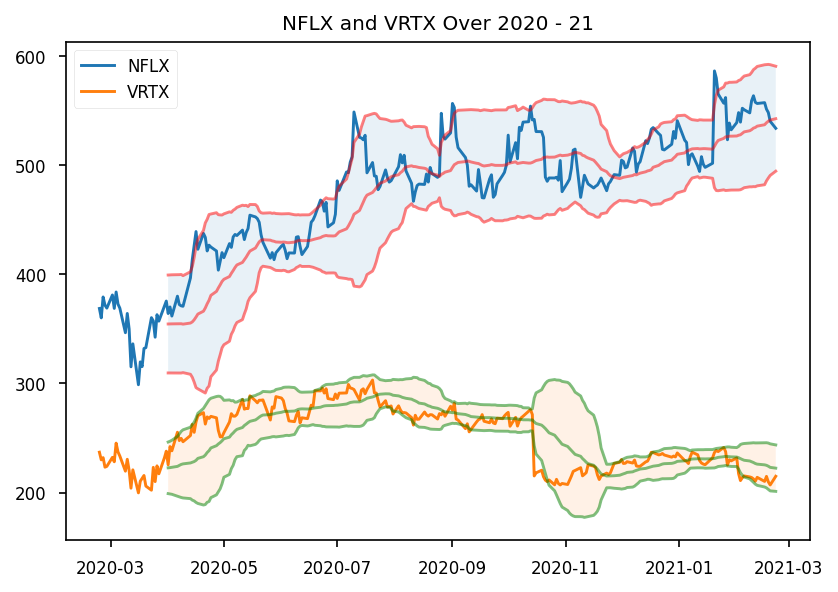

NFLX VRTX
Spread is Cointegrated at 1% Significance Level


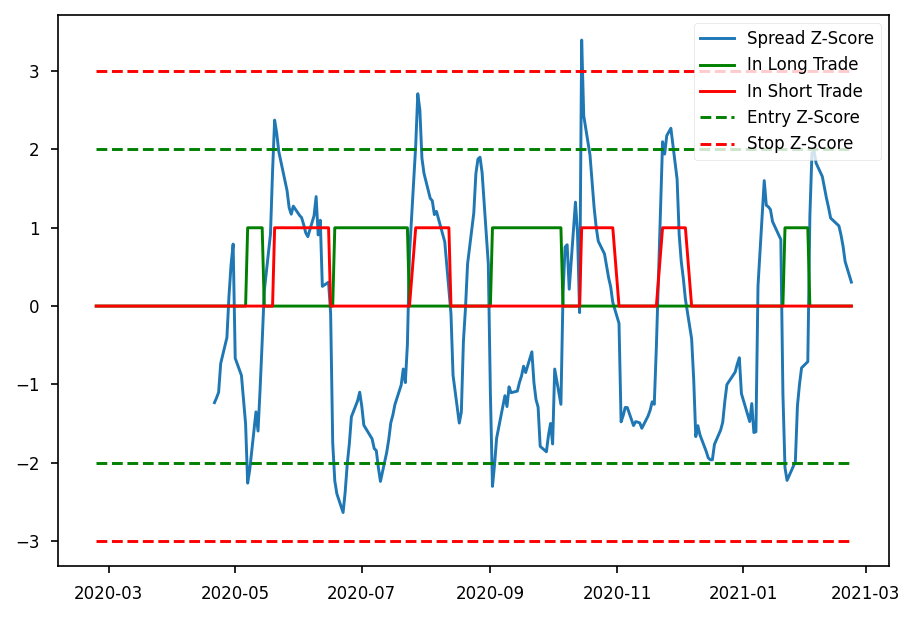

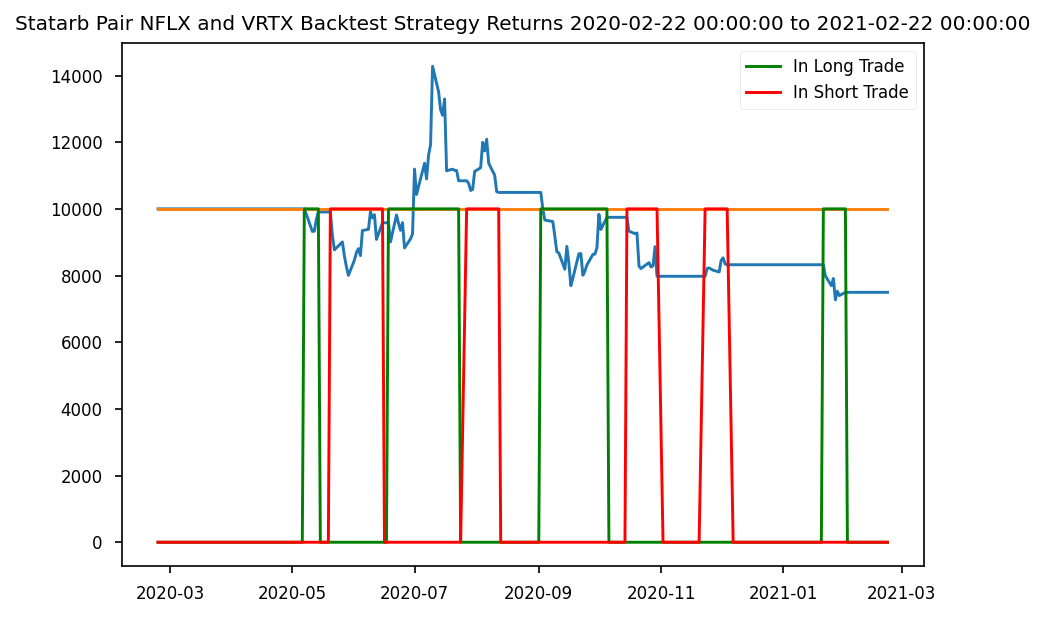

SBAC_VRTX


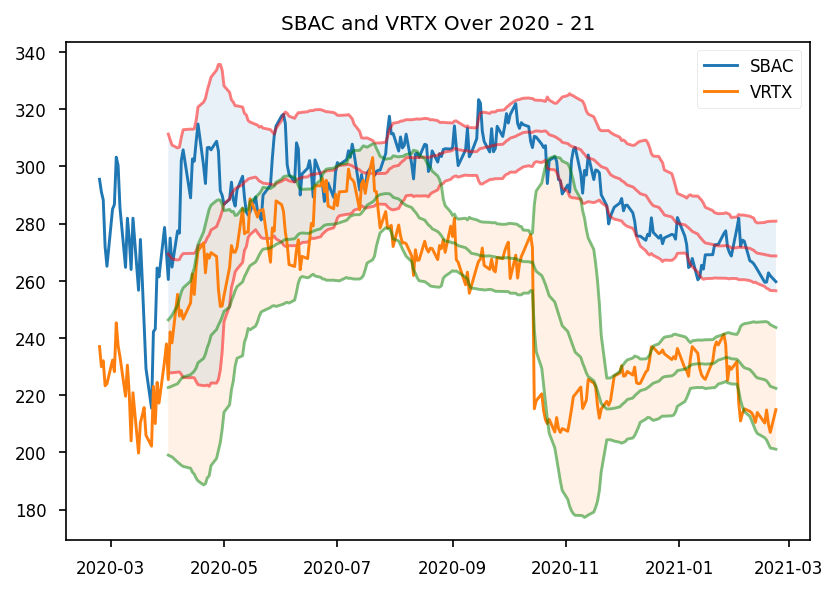

SBAC VRTX
Spread is Cointegrated at 5% Significance Level


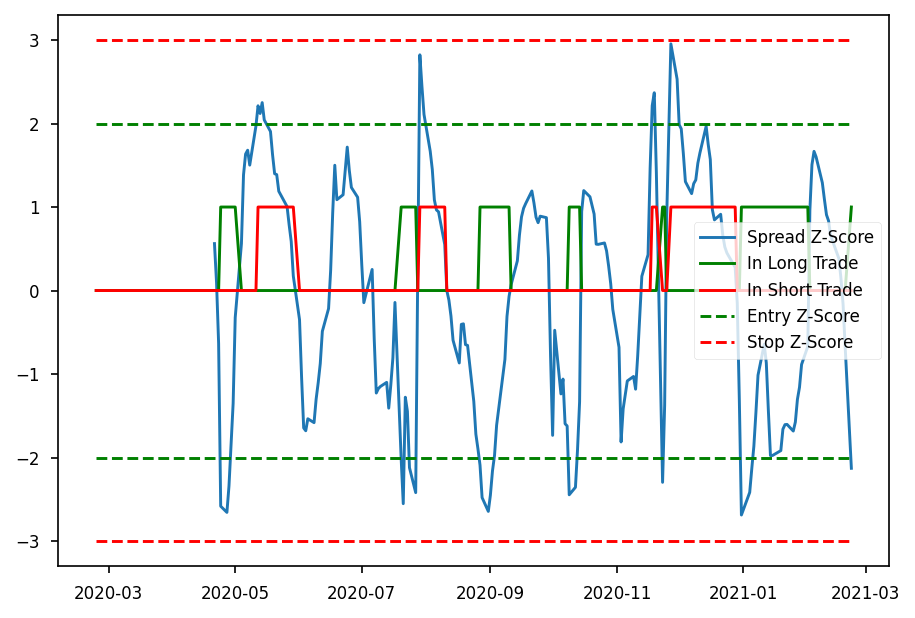

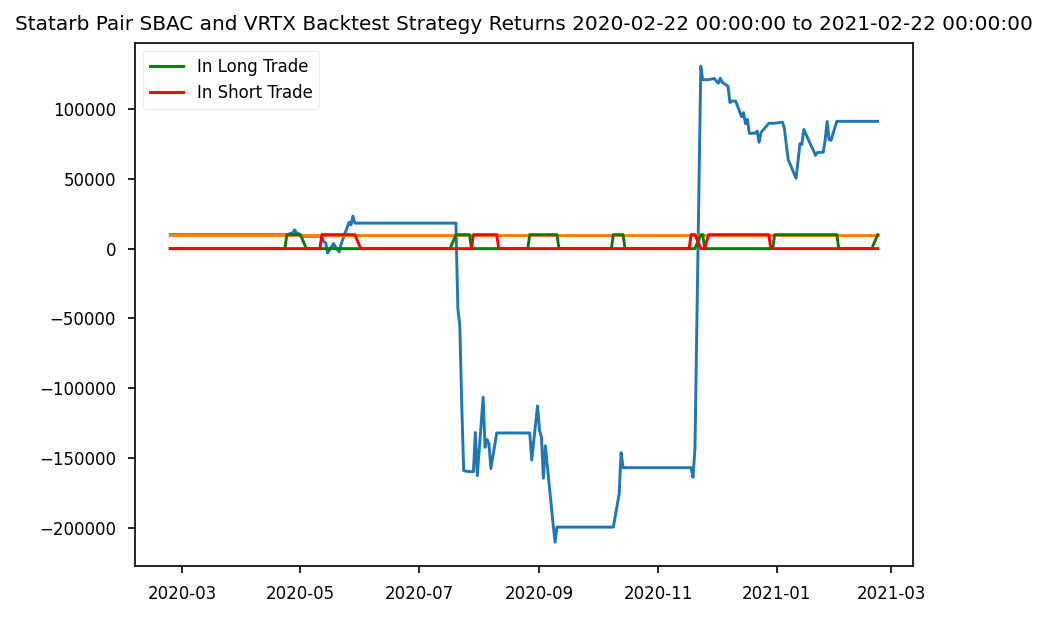

In [11]:
from datetime import datetime
number_of_pairs = len(pairs)
start = datetime(2020, 2, 22)
end = datetime(2021, 2, 22)

trade_data = []
for i in range(number_of_pairs):
    p = pd.DataFrame()
    name_1 = pairs[i][0]
    name_2 = pairs[i][1]
    title = name_1 + " and " + name_2 + " Backtest"
    col_add = name_1 + "_" + name_2
    print(col_add)
    s1 = pdr.get_data_yahoo(name_1, start, end)
    s2 = pdr.get_data_yahoo(name_2, start, end)
    pair = statarb(s1, s2, name_1, name_2, 14, -2, 2, -3.0, 3.0, 28, start, end)
    pair.create_spread()
    print(name_1, name_2)
    pair.check_cointergration()
    pair.generate_signal()
    p_pair = pair.generate_returns(10000, title)
    p[col_add + '_Positions'] = p_pair['Positions']
    p[col_add + '_X'] = p_pair[name_1]
    p[col_add + '_Y'] = p_pair[name_2]
    p[col_add + '_Total'] = p_pair['Total']
    p[col_add + '_Returns'] = p_pair['Returns']
    p[col_add + '_Win'] = p_pair['Win']
    p[col_add + '_Loss'] = p_pair['Loss']
    p[col_add + '_Trade_Returns'] = p_pair['Trade_Returns']
    p[col_add + '_Position_Value'] = p_pair['Portfolio_Value']
    trade_data.append(p)


In [345]:
trade_data[0].describe()

,EOG_NFLX_Positions,EOG_NFLX_X,EOG_NFLX_Y,EOG_NFLX_Total,EOG_NFLX_Returns,EOG_NFLX_Win,EOG_NFLX_Loss,EOG_NFLX_Trade_Returns,EOG_NFLX_Position_Value
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,80.000000,252.000000
mean,-0.043651,3.191468,-21.317540,-18.126071,1.078488,0.162698,0.083333,NaN,10784.880608
std,0.530052,24.478619,257.379246,233.613540,0.110825,0.369825,0.276935,NaN,1108.246641
min,-1.000000,-52.730000,-586.340027,-526.140026,0.919776,0.000000,0.000000,-inf,9197.761618
25%,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.028445,10000.000000
50%,0.000000,-0.000000,0.000000,0.000000,1.035579,0.000000,0.000000,0.004016,10355.786210
75%,0.000000,-0.000000,0.000000,0.000000,1.130329,0.000000,0.000000,0.018583,11303.286187
max,1.000000,62.439999,527.510010,492.650009,1.377252,1.000000,1.000000,inf,13772.518631


In [346]:
trade_data[1].describe()

,EOG_SBAC_Positions,EOG_SBAC_X,EOG_SBAC_Y,EOG_SBAC_Total,EOG_SBAC_Returns,EOG_SBAC_Win,EOG_SBAC_Loss,EOG_SBAC_Trade_Returns,EOG_SBAC_Position_Value
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,122.000000,252.000000
mean,0.023810,-0.910238,5.616150,4.705912,0.981731,0.178571,0.226190,NaN,9817.305120
std,0.667567,31.745955,195.783449,164.754972,0.055202,0.383755,0.419196,NaN,552.018046
min,-1.000000,-63.540001,-323.350006,-284.760006,0.789956,0.000000,0.000000,-inf,7899.559399
25%,0.000000,-0.000000,0.000000,0.000000,0.966857,0.000000,0.000000,-0.024231,9668.566192
50%,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.005881,10000.000000
75%,0.000000,-0.000000,0.000000,0.000000,1.013943,0.000000,0.000000,0.011211,10139.430031
max,1.000000,54.680000,314.170013,272.830002,1.072794,1.000000,1.000000,inf,10727.942601


In [347]:
trade_data[2].describe()

,EOG_VRTX_Positions,EOG_VRTX_X,EOG_VRTX_Y,EOG_VRTX_Total,EOG_VRTX_Returns,EOG_VRTX_Win,EOG_VRTX_Loss,EOG_VRTX_Trade_Returns,EOG_VRTX_Position_Value
count,252.00000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,146.000000,252.000000
mean,-0.06746,3.652976,-15.011825,-11.358849,1.013275,0.246032,0.242063,NaN,10132.745646
std,0.73026,36.082140,182.967776,147.772152,0.120078,0.431554,0.429185,NaN,1200.779953
min,-1.00000,-63.099998,-295.799988,-249.050011,0.776808,0.000000,0.000000,-inf,7768.080712
25%,-1.00000,-0.000000,-218.137501,-173.387506,0.918763,0.000000,0.000000,-0.025126,9187.633501
50%,0.00000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.001708,10000.000000
75%,0.00000,39.057500,0.000000,0.000000,1.118359,0.000000,0.000000,0.017217,11183.586290
max,1.00000,66.099998,287.959991,236.989990,1.250495,1.000000,1.000000,inf,12504.952701


In [348]:
trade_data[3].describe()

,NFLX_SBAC_Positions,NFLX_SBAC_X,NFLX_SBAC_Y,NFLX_SBAC_Total,NFLX_SBAC_Returns,NFLX_SBAC_Win,NFLX_SBAC_Loss,NFLX_SBAC_Trade_Returns,NFLX_SBAC_Position_Value
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,141.000000,252.000000
mean,0.000000,-8.510159,1.068432,-7.441727,0.814199,0.226190,0.257937,NaN,8141.989204
std,0.725187,365.855709,210.591475,157.994966,0.146915,0.419196,0.438370,NaN,1469.150953
min,-1.000000,-586.340027,-318.260010,-313.800018,0.600476,0.000000,0.000000,-inf,6004.765000
25%,-1.000000,-479.437508,-260.543755,-177.332504,0.667721,0.000000,0.000000,-0.043968,6677.206187
50%,0.000000,-0.000000,0.000000,0.000000,0.780077,0.000000,0.000000,-0.010158,7800.767465
75%,1.000000,419.770012,264.402496,107.324997,1.000000,0.000000,1.000000,0.026596,10000.000000
max,1.000000,557.280029,315.320007,297.780029,1.103191,1.000000,1.000000,inf,11031.911040


In [349]:
trade_data[4].describe()

,NFLX_VRTX_Positions,NFLX_VRTX_X,NFLX_VRTX_Y,NFLX_VRTX_Total,NFLX_VRTX_Returns,NFLX_VRTX_Win,NFLX_VRTX_Loss,NFLX_VRTX_Trade_Returns,NFLX_VRTX_Position_Value
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,122.000000,252.000000
mean,0.039683,-24.195318,15.293214,-8.902104,0.933705,0.202381,0.218254,NaN,9337.049869
std,0.672757,325.753518,177.852676,152.021731,0.123916,0.402574,0.413883,NaN,1239.162949
min,-1.000000,-579.840027,-287.959991,-341.200027,0.727074,0.000000,0.000000,-inf,7270.738261
25%,0.000000,-0.000000,0.000000,0.000000,0.832391,0.000000,0.000000,-0.046550,8323.913198
50%,0.000000,-0.000000,0.000000,0.000000,0.958251,0.000000,0.000000,-0.005496,9582.513949
75%,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.027063,10000.000000
max,1.000000,541.940002,303.100006,326.660004,1.427608,1.000000,1.000000,inf,14276.080662


In [350]:
trade_data[5].describe()

,SBAC_VRTX_Positions,SBAC_VRTX_X,SBAC_VRTX_Y,SBAC_VRTX_Total,SBAC_VRTX_Returns,SBAC_VRTX_Win,SBAC_VRTX_Loss,SBAC_VRTX_Trade_Returns,SBAC_VRTX_Position_Value
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,105.000000,252.000000
mean,0.015873,-4.256230,3.945000,-0.311230,-2.850996,0.158730,0.182540,NaN,-28509.955831
std,0.618237,178.865988,156.528200,25.234321,10.275820,0.366151,0.387057,NaN,102758.196906
min,-1.000000,-314.630005,-288.690002,-68.399994,-21.021869,0.000000,0.000000,-inf,-210218.693829
25%,0.000000,-0.000000,0.000000,0.000000,-14.143431,0.000000,0.000000,-0.176062,-141434.314614
50%,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.037335,10000.000000
75%,0.000000,-0.000000,0.000000,0.000000,1.841522,0.000000,0.000000,0.092083,18415.221450
max,1.000000,317.570007,303.100006,85.790009,13.054317,1.000000,1.000000,inf,130543.167633
